# Replication of Nanni et al. SemScale's Paper

This notebook attempts to recreate and expand upon the results and methodology by Nanni et al. in their found in SemScale paper. 

We study at the **english** 5th and 6th legislation of their EuroParl dataset, which exists in an updated, fixed version, differing from the paper. In communication with Federico Nanni, he endeavors to update his results with this fixed version.

We recreate the results by running the data of both legislations through SemScale and Wordfish, but also expand upon the results, by comparing them with a pre-processed version.

## Download Data

For this notebook, we need files which are too large for git. We will check if they are inside the project's folder, and if not, we download them.

We check whether SemScale's embeddings file exists on the user's computer, if not, we download it:

In [1]:
import gdown # Library for downloading from Google Drive
import os
# Check if file already exists
if not os.path.isfile("embeddings_semscale.vec"):
    # Download file
    print("Downloading file, please wait...")
    
    url = "https://drive.google.com/uc?id=1Oy61TV0DpruUXOK9qO3IFsvL5DMvwGwD&export=download"
    output_path = 'embeddings_semscale.vec'
    gdown.download(url,output_path)
                      
    print("Done!")

We check for the EuroParl dataset:

In [2]:
import urllib.request
from io import BytesIO
import zipfile
# Check if file already exists
if not os.path.exists("europarl_v102"):
    # Download file
    print("Downloading file, please wait...")
    
    url = "https://cloud.uni-koblenz-landau.de/s/Mw4kECRq6RyFCbL/download"
    output_path = 'europarl_v102.zip'
    urllib.request.urlretrieve(url, output_path)
    print("Done downloading, will extract now...")
    
    with zipfile.ZipFile("europarl_v102.zip","r") as zip_file:
        zip_file.extractall()
    # We delete the zip form the disk to make space
    # os.system("rm europarl_v102.zip")
    # We write the extracted zip to the disk again
    print("Done!")

Now that we downloaded everything, we create a variable to store the current time, so we can see how long the computation will take:

In [3]:
import datetime
start_time = datetime.datetime.now()

Since this is a python notebook, we need to use rpy2 to be able to run R code.
The next cell allows us to run rpy2 in notebook cells and later import R variables into the python environment of this notebook.

In [4]:
%load_ext rpy2.ipython
import rpy2.robjects as robjects

Cells including the line **%%R** contain R code.

Cells including the line **%%capture** do not print the output of that cell (for example because it is not of importance for the reader of the notebook).

We start our R session with imports of R libraries:

In [5]:
%%R
# Load R libraries
library(quanteda)
library(RSQLite)
library(caret)
library(mltools)
library(glue)
library(tm)

R[write to console]: Package version: 1.5.2

R[write to console]: Parallel computing: 2 of 8 threads used.

R[write to console]: See https://quanteda.io for tutorials and examples.

R[write to console]: 
Attaching package: ‘quanteda’


R[write to console]: The following object is masked from ‘package:utils’:

    View


R[write to console]: Loading required package: lattice

R[write to console]: Loading required package: ggplot2

R[write to console]: Loading required package: NLP

R[write to console]: 
Attaching package: ‘NLP’


R[write to console]: The following object is masked from ‘package:ggplot2’:

    annotate


R[write to console]: 
Attaching package: ‘tm’


R[write to console]: The following objects are masked from ‘package:quanteda’:

    as.DocumentTermMatrix, stopwords




We load the textfiles which store the speeches and apply basic preprocessing:

In [6]:
%%R
getSpeechesWithScores <- function(relative_txt_path, relative_scores_path) {
  
  file_name = list.files(relative_txt_path)
  
  file_path = paste0(relative_txt_path, file_name)
  
  content <- sapply(file_path, FUN = function(file)readChar(file, file.info(file)$size))
  
  # Create dataframe
  df <- data.frame(file_name=file_name, content=content, stringsAsFactors=FALSE)
  
  # Read scores
  scores <- read.csv(relative_scores_path, sep=' ', header = FALSE)
  # Set column names
  names(scores) <- c("file_name", "score")
  
  # Merge two dataframes to only keep those with score
  merged_df = merge(x = df, y = scores, by = "file_name")

  # Replaced processed text inside dataframe
  content_df = merged_df['content']
  
  # Drop file name as not needed anymore
  merged_df$file_name <- NULL
  
  return (merged_df)
}

# Get Dataframes for fifth and sixth legislations
fifth_df <- getSpeechesWithScores(relative_txt_path = "./europarl_v102/5/EN/", relative_scores_path = "./europarl_v102/5/ideology.txt")
sixth_df <- getSpeechesWithScores(relative_txt_path = "./europarl_v102/6/EN/", relative_scores_path = "./europarl_v102/6/ideology.txt")

# We remove the EN at the start of the speeches, which has been put there to 
# indicate the language for SemScale. 
# For SemScale, we specifically add it later again, here we however remove it for Wordfish.
fifth_df$content <- sub("EN", "", fifth_df$content)
sixth_df$content <- sub("EN", "", sixth_df$content)

Let us look at an example speech:

In [7]:
%%R
# Because the entire string is so long, we only show the some characters of it
substr(fifth_df[1,'content'], start = 1, stop = 1000)

[1] "\n– Mr President, we have to restore public confidence in aviation and we have to let the market decide what happens to the airlines themselves. Restoring public confidence means getting security screening right and improving the quality of staff, training, job procedures, pay and conditions. It means, perhaps, ensuring that there is a state-run security operation at airports and paying accordingly. That may well create more jobs. So far as the airlines and their financial viability are concerned, we do not want more intervention, more bureaucracy and more delay. We need targeted assistance in areas like insurance and the cost of security. We must let the market decide what the future of the airline industry shall be. As was said earlier, Sabena made a profit in only one year out of the many years that it has been in existence. Aer Lingus, Alitalia, Air France and KLM are not far behind. Why the devil should we support Aer Lingus when Ryanair can make money without any difficultie

In order to observe the effects of proprocessing, we want to create a second version of the two legislation datasets, on which apply **further text preprocessing**, which is:

- **Lowercasing**: Set all upper case letters to lower case. This helps us reduce the count of words.


- **Removal of punctuation and numbers**:  Punctuation and numbers are not of benefit for our word frequency methods, as they give little semantic information when their count per document appears in a document-feature matrix or a token count vector.


- **Removal of stopwords**: Stopwords such as "the" or "is" and others are not words containing a direct sentiment on their own and are thus removed.


- **Stemming**: Words in the texts are pruned to their base form, e.g. "runner" and "running" may be pruned to "run". This is already an example of what problems stemming may cause (e.g. turning verbs into nouns), however, it greatly reduces the number of words inside a text corpus and is thus beneficial for our word frequency methods.


- **Removal of extra whitespace**: Through previous preprocessing and through faults in the dataset, extra whitespace in the text may exist which is removed.

We now apply the preprocessing steps mentioned above:

In [8]:
%%R

preprocess_documents <- function(unprocessed_docs){

  # Create corpus for cleanup methods
  corpus <- (VectorSource(unprocessed_docs))
  corpus <- Corpus(corpus)
  
  # Clean up corpus
  corpus_clean <- tm_map(corpus, content_transformer(tolower))
  corpus_clean <- tm_map(corpus_clean, removePunctuation)
  corpus_clean <- tm_map(corpus_clean, removeNumbers)
  corpus_clean <- tm_map(corpus_clean, removeWords, stopwords('english'))
  corpus_clean <- tm_map(corpus_clean, stemDocument, language = "english")
  corpus_clean <- tm_map(corpus_clean, stripWhitespace)
  
  # Revert to string
  processed_docs <- sapply(corpus_clean$content, as.character)
  return (unname(processed_docs)) # Needs to be an unnamed list
}

# We remove symbols and digits
fifth_df$content <- gsub("[^<>'?!.:,a-zA-Z]", " ", fifth_df$content)

# We remove the extra created whitespace
fifth_df$content <- gsub("\\s+"," ", fifth_df$content)

fifth_df_processed = fifth_df
fifth_df_processed$content <- preprocess_documents(fifth_df$content)

# We remove symbols and digits
sixth_df$content <- gsub("[^<>'?!.:,a-zA-Z]", " ", sixth_df$content)

# We remove the extra created whitespace
sixth_df$content <- gsub("\\s+"," ", sixth_df$content)

sixth_df_processed = sixth_df
sixth_df_processed$content <- preprocess_documents(sixth_df$content)

We shuffle the data:

In [9]:
%%R
# Shuffle the data
# The way R works, a seed has to be set again before every randomized action
set.seed(42)
fifth_df <- fifth_df[sample(nrow(fifth_df)),]
set.seed(42)
fifth_df_processed <- fifth_df_processed[sample(nrow(fifth_df_processed)),]

set.seed(42)
sixth_df <- sixth_df[sample(nrow(sixth_df)),]
set.seed(42)
sixth_df_processed <- sixth_df_processed[sample(nrow(sixth_df_processed)),]


Create DFMs for training:

In [10]:
%%R

dfm_fifth <- dfm(fifth_df$content)
dfm_fifth_processed <- dfm(fifth_df_processed$content)

dfm_sixth <- dfm(sixth_df$content)
dfm_sixth_processed <- dfm(sixth_df_processed$content)

DFMs <- list(dfm_fifth, dfm_fifth_processed, dfm_sixth, dfm_sixth_processed)
Ys <- list(fifth_df$score, fifth_df$score, sixth_df$score, sixth_df$score)

We calculate the *mean-squared-error* and *pearson* and *spearman correlation* for use of a method on a datset. At the end of the notebook, we present these results.

For this, we initialize a dataframe to record the data:

In [11]:
import pandas as pd
import numpy as np
metrics_fifth_df = pd.DataFrame(columns=["Method", 
                                         "MSE", "MSE Processed",
                                         "Pearson", "Pearson Processed",
                                         "Spearman", "Spearman Processed"])

metrics_sixth_df = pd.DataFrame(columns=["Method", 
                                         "MSE", "MSE Processed",
                                         "Pearson", "Pearson Processed",
                                         "Spearman", "Spearman Processed"])

# Methods

## Wordfish (frequency method)
Wordfish requires two labeled documents with opposite political positions as reference documents and from that Wordfish positions the other documents in relation to these two reference documents, as the reference documents get assigned both ends of the output scale. No further training is required. In order to simulate the typical train/test-data environment, we take two labeled documents from the training-data and append them to the test-data. On this, we will then run Wordfish.

First we need to find opposite documents:

In [12]:
%%R
print(glue("Min fifth_df: {which.min(fifth_df$score)}"))
print(glue("Max fifth_df: {which.max(fifth_df$score)}"))
print(glue("---"))
print(glue("Min fifth_df_processed: {which.min(fifth_df_processed$score)}"))
print(glue("Max fifth_df_processed: {which.max(fifth_df_processed$score)}"))
print(glue("---"))
print(glue("Min sixth_df: {which.min(sixth_df$score)}"))
print(glue("Max sixth_df: {which.max(sixth_df$score)}"))
print(glue("---"))
print(glue("Min sixth_df_processed: {which.min(sixth_df_processed$score)}"))
print(glue("Max sixth_df_processed: {which.max(sixth_df_processed$score)}"))
print(glue("---"))

Min fifth_df: 7
Max fifth_df: 28
---
Min fifth_df_processed: 7
Max fifth_df_processed: 28
---
Min sixth_df: 7
Max sixth_df: 8
---
Min sixth_df_processed: 7
Max sixth_df_processed: 8
---


We save the reference documents in the variable *wf_train_docs*:

In [13]:
%%R
wf_train_docs <- list()
# We select the documents from the training data by boolean values as indices
wf_train_docs[[1]] = dfm_subset(dfm_fifth, c(rep(FALSE,6), TRUE, rep(FALSE, 20), TRUE, rep(FALSE, nrow(fifth_df) - 28)))
wf_train_docs[[2]] = dfm_subset(dfm_fifth_processed, c(rep(FALSE,6), TRUE, rep(FALSE, 20), TRUE, rep(FALSE, nrow(fifth_df_processed) - 28)))
wf_train_docs[[3]] = dfm_subset(dfm_sixth, c(rep(FALSE, 6), TRUE, TRUE, rep(FALSE, nrow(sixth_df) - 8)))
wf_train_docs[[4]] = dfm_subset(dfm_sixth_processed, c(rep(FALSE, 6), TRUE, TRUE, rep(FALSE, nrow(sixth_df_processed) - 8)))

We check if the variable indeed contains the training texts:

In [14]:
%%R
for (i in 1:4) {
    print(wf_train_docs[[i]][1:2,1])
}

Document-feature matrix of: 2 documents, 1 feature (0.0% sparse).
2 x 1 sparse Matrix of class "dfm"
        features
docs      mr
  text7  534
  text28 255
Document-feature matrix of: 2 documents, 1 feature (0.0% sparse).
2 x 1 sparse Matrix of class "dfm"
        features
docs      mr
  text7  534
  text28 255
Document-feature matrix of: 2 documents, 1 feature (0.0% sparse).
2 x 1 sparse Matrix of class "dfm"
       features
docs      .
  text7 447
  text8 573
Document-feature matrix of: 2 documents, 1 feature (0.0% sparse).
2 x 1 sparse Matrix of class "dfm"
       features
docs    madam
  text7     4
  text8     9


As we can see, the texts form above are indeed inside the *wf_train_docs* document-feature matrix.

We append these two documents to the test-data, creating the variable *data_wf*. We then calculate the Wordfish results and save them in *wf_results*:

In [15]:
%%R
data_wf <- list()
wf_results <- list() 
for (i in 1:4) {
    print(glue("Handling fold {i} out of 4"))
    data_wf[[i]] <- rbind(wf_train_docs[[i]], DFMs[[i]]) # Add the two training docs at the top
    data_wf[[i]] <- dfm_trim(data_wf[[i]], min_docfreq = 1) # Only leave in terms that appear at least once.
                                                            # Wordfish does this anyway, but we prevent lengthy
                                                            # printouts if we do it ourselves.
    set.seed(42)
    wf_results[[i]] <- textmodel_wordfish(data_wf[[i]], dir=c(1,2) , sparse = TRUE)$theta
}

Handling fold 1 out of 4
Handling fold 2 out of 4
Handling fold 3 out of 4
Handling fold 4 out of 4


We drop the two reference documents which were put at the beginning of *wf_results* from every fold:

In [16]:
%%R
for (i in 1:4) {
wf_results[[i]] <- wf_results[[i]][- c(1,2)]
}

We min-max normalize the Wordfish results to make them comparable to our other methods:

In [17]:
%%R
# Define normalization function
normalize <- function(x){(x-min(x))/(max(x)-min(x))}

wf_results_normalized <- list()
for (i in 1:4) {
wf_results_normalized[[i]] <- normalize(wf_results[[i]])
}

We plot the normalized Wordfish results:

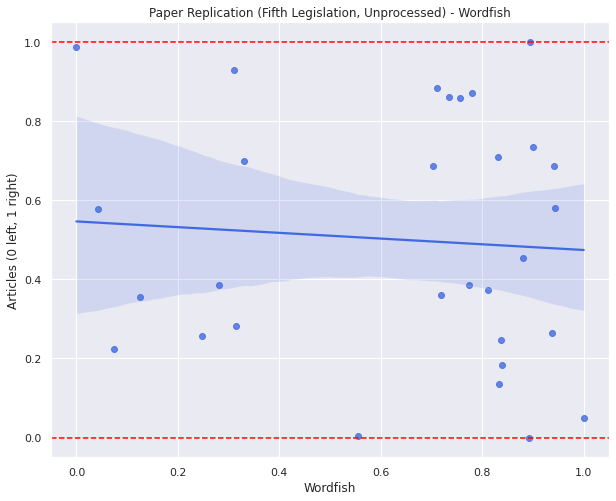

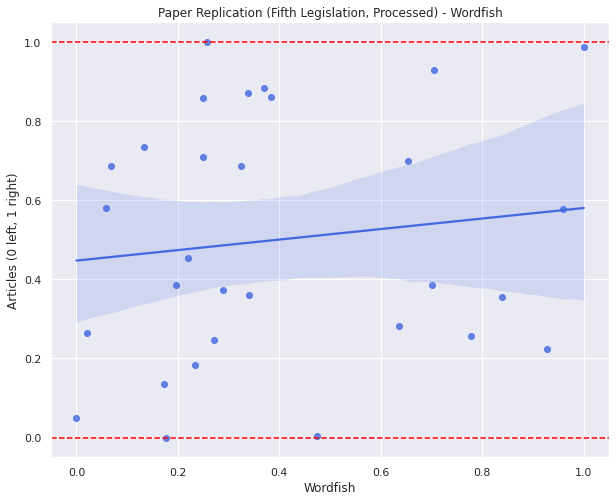

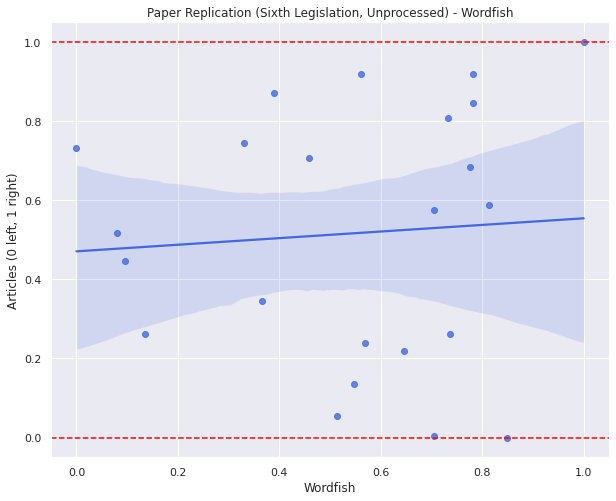

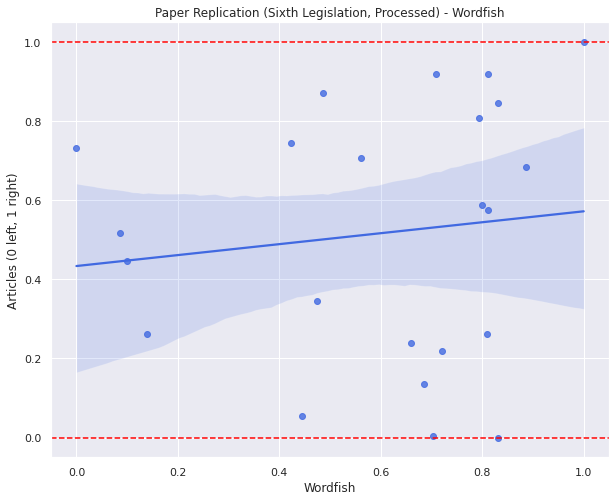

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import os
import logging
import warnings
warnings.filterwarnings("ignore") 
import logging
logger = logging.getLogger().setLevel(logging.ERROR)
# Get number of folds
# For the int() to work, we first need to convert it to a numpy array
method_name = "Wordfish"
notebook_name = "Paper Replication"
fig_dir = "figs/" + notebook_name  + "/" + method_name + "/"

#X = np.array(robjects.r['Ys'])
#y = np.array(robjects.r['wf_results_normalized'])

y = np.array(robjects.r['Ys'])
X = np.array(robjects.r['wf_results_normalized'])
for i in range(4): 
    X[i] = np.array(X[i], dtype = np.float64)
    y[i] = np.array(y[i], dtype = np.float64)

if not os.path.isdir(fig_dir):
    os.makedirs(fig_dir)
for i in range(4):
    sns.set(rc={'figure.figsize':(10,8)})
    fig = sns.regplot(x=X[i], y=y[i], color="royalblue")
    fig.set_xlim(-0.05,1.05) # So points aren't cut off on the sides
    plt.axhline(1, ls='--', color="red")
    plt.axhline(0, ls='--', color="red")
    #fig.set_xlabel("Articles (0 left, 1 right)")
    #fig.set_ylabel(method_name)
    fig.set_ylabel("Articles (0 left, 1 right)")
    fig.set_xlabel(method_name)
    if i == 0:
        notebook_name = "Paper Replication (Fifth Legislation, Unprocessed)"
        fig.set_title(notebook_name + " - " + method_name)
    elif i == 1:
        notebook_name = "Paper Replication (Fifth Legislation, Processed)"
        fig.set_title(notebook_name + " - " + method_name)
    elif i == 2:
        notebook_name = "Paper Replication (Sixth Legislation, Unprocessed)"
        fig.set_title(notebook_name + " - " + method_name)
    elif i == 3:
        notebook_name = "Paper Replication (Sixth Legislation, Processed)"
        fig.set_title(notebook_name + " - " + method_name)
    fig.get_figure().savefig(fig_dir + method_name + notebook_name + ".pdf")
    fig.get_figure().savefig(fig_dir + method_name + notebook_name + ".svg")
    plt.show()

We extract different MSEs for later comparison with the other methods:

In [19]:
%%R
MSEs_wf <- mapply(mse, wf_results_normalized, Ys)

We also extract Pearson and Spearman correlation:

In [20]:
%%R
cor_p_wf <- mapply(cor, wf_results_normalized, Ys, method="pearson")
cor_s_wf <- mapply(cor, wf_results_normalized, Ys, method="spearman")

In [21]:
MSEs_wf = np.array(robjects.r['MSEs_wf'])
cor_p_wf = np.array(robjects.r['cor_p_wf'])
cor_s_wf = np.array(robjects.r['cor_s_wf'])

metrics_fifth_df = metrics_fifth_df.append(
            {"Method": "Wordfish",
             "MSE": MSEs_wf[0],
             "MSE Processed": MSEs_wf[1],
             "Pearson":cor_p_wf[0],
             "Pearson Processed":cor_p_wf[1],
             "Spearman": cor_s_wf[0],
             "Spearman Processed": cor_s_wf[1]},
            ignore_index=True)

metrics_sixth_df = metrics_sixth_df.append(
            {"Method": "Wordfish",
             "MSE": MSEs_wf[2],
             "MSE Processed": MSEs_wf[3],
             "Pearson":cor_p_wf[2],
             "Pearson Processed":cor_p_wf[3],
             "Spearman": cor_s_wf[2],
             "Spearman Processed": cor_s_wf[3]},
            ignore_index=True)

## SemScale (semantic method)

SemScale does not need training, thus we immediately input the test data. SemScale cannot be executed easily inside this notebook, as they are separate files published by the authors, supposed to be started via a bash command (which we will do here).

In order to run SemScale, we have to output our data into .txt files, and add a line with "en" to beginning of each text file. SemScale needs this to classify it as an English text.

We add the "en" at the beginning of each data point using the **unprocessed** variables:

In [22]:
%%R
X_fifth_sem <- paste("en", fifth_df$content, sep="\n")
X_fifth_processed_sem <- paste("en", fifth_df_processed$content, sep="\n")
X_sixth_sem <- paste("en", sixth_df$content, sep="\n")
X_sixth_processed_sem <- paste("en", sixth_df_processed$content, sep="\n")

# Combine all of them
X_sem <- list(X_fifth_sem, X_fifth_processed_sem, X_sixth_sem, X_sixth_processed_sem)

We then create the aforementioned .txt files:

In [23]:
%%R
txt_folders <- list()
txt_folders[[1]] = "txts/txts_europarl_fifth"
txt_folders[[2]] = "txts/txts_europarl_fifth_processed"
txt_folders[[3]] = "txts/txts_europarl_sixth"
txt_folders[[4]] = "txts/txts_europarl_sixth_procesed"

In [24]:
%%R
for (i in 1:length(txt_folders)) {
  # Create folders for the text files
  folder_for_fold = glue(paste0(txt_folders[[i]]))
  dir.create(folder_for_fold)
  # Create text files
  for (j in 1:length(X_sem[[i]])){
  filename = glue(paste0(folder_for_fold, "/{Ys[[i]][j]}_speech.txt"))
  write.table(X_sem[[i]][j], file=filename, row.names = FALSE, col.names=FALSE, quote=FALSE)
  }
}

We now call the SemScale script by using the bash console (if you started this notebook via bash, you can see the prints of SemScale in it):

In [25]:
%%R
for (i in 1:length(txt_folders)){
  folder_for_fold = glue(paste0(txt_folders[[i]]))
  # Execute in bash (Commented out so it doesn't run the process when running the notebook)
  print(glue("Processing folder {i} out of {length(txt_folders)}..."))
  # Because R does not support string concatiation via "+" we must take construct the string in parts...
  script_pt1 = glue(paste0("cd SemScale-master && python scaler.py ../", folder_for_fold))
  full_script = full_cmd = glue(paste(script_pt1, "../embeddings_semscale.vec ./../semscale_outputs/semscale_output_europarl_replication_{i}.txt"))
  
  #system(full_script)
}

Processing folder 1 out of 4...
Processing folder 2 out of 4...
Processing folder 3 out of 4...
Processing folder 4 out of 4...


The cell above outputs .csv files including the scores, which we now read back into our notebook:

In [26]:
%%R
sem_outputs <- list()
for (i in 1:length(txt_folders)){
  # Read each file
  sem_outputs[[i]] <- read.csv(glue("semscale_outputs/semscale_output_europarl_replication_{i}.txt"), sep="\t", header=FALSE)
}

We add back target labels (0/1 for left/right) to the output of SemScale, "sem_outputs":

In [27]:
%%R
for (i in 1:length(txt_folders)) {
  for (j in seq_along(sem_outputs[[i]][,1])) {
    sem_outputs[[i]][j,3] <- sub("\\_.*", "", sem_outputs[[i]][j,1])
  }
}


We plot the SemScale results (just as we did with Wordscores and Wordfish):

In [28]:
%%R
plot_sem_result <- list()
plot_target <- list()
for (i in 1:length(txt_folders)) {
    plot_sem_result[[i]] = sem_outputs[[i]][,2]
    plot_target[[i]] = sem_outputs[[i]][,3]
}

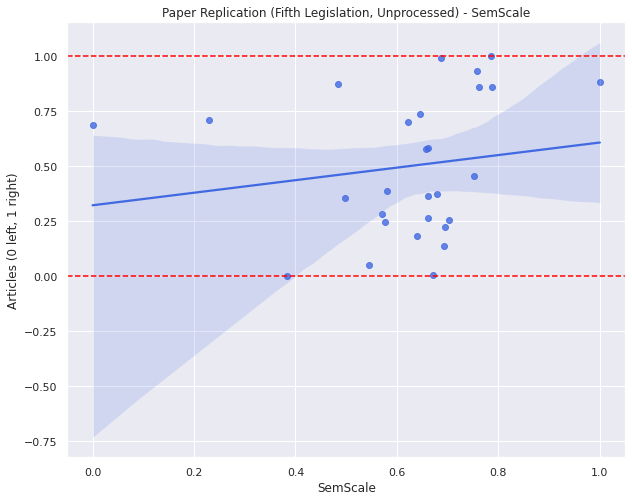

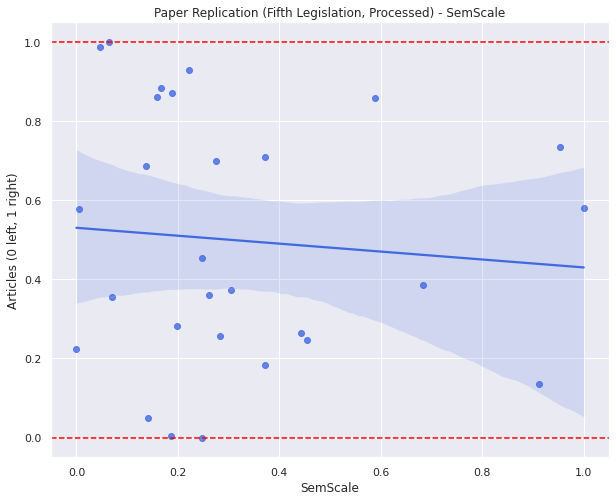

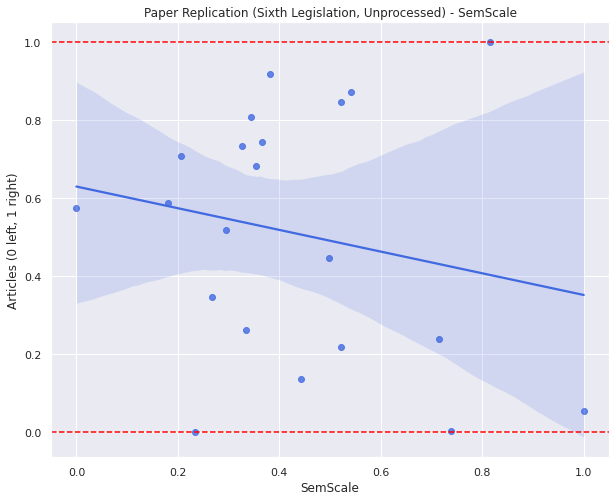

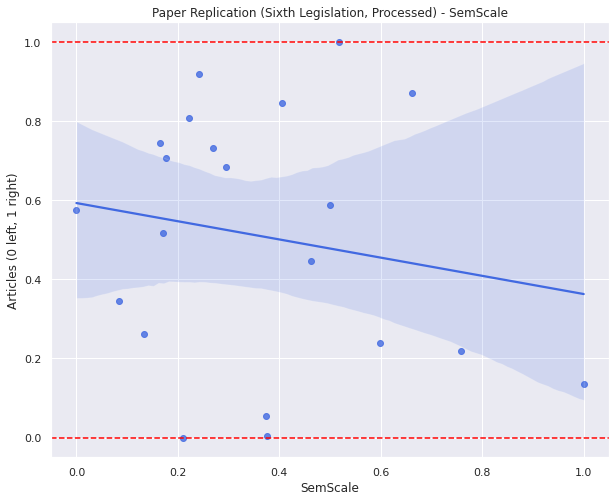

In [29]:
method_name = "SemScale"
notebook_name = "Paper Replication"
fig_dir = "figs/" + notebook_name  + "/" + method_name + "/"

#X = np.array(robjects.r['plot_target'])
#y = np.array(robjects.r['plot_sem_result'])
y = np.array(robjects.r['plot_target'])
X = np.array(robjects.r['plot_sem_result'])
for i in range(4): 
    X[i] = np.array(X[i], dtype = np.float64)
    y[i] = np.array(y[i], dtype = np.float64)

if not os.path.isdir(fig_dir):
    os.makedirs(fig_dir)
for i in range(4):
    sns.set(rc={'figure.figsize':(10,8)})
    fig = sns.regplot(x=X[i], y=y[i], color="royalblue")
    fig.set_xlim(-0.05,1.05) # So points aren't cut off on the sides
    plt.axhline(1, ls='--', color="red")
    plt.axhline(0, ls='--', color="red")
    #fig.set_xlabel("Articles (0 left, 1 right)")
    #fig.set_ylabel(method_name)
    fig.set_ylabel("Articles (0 left, 1 right)")
    fig.set_xlabel(method_name)
    if i == 0:
        notebook_name = "Paper Replication (Fifth Legislation, Unprocessed)"
        fig.set_title(notebook_name + " - " + method_name)
    elif i == 1:
        notebook_name = "Paper Replication (Fifth Legislation, Processed)"
        fig.set_title(notebook_name + " - " + method_name)
    elif i == 2:
        notebook_name = "Paper Replication (Sixth Legislation, Unprocessed)"
        fig.set_title(notebook_name + " - " + method_name)
    elif i == 3:
        notebook_name = "Paper Replication (Sixth Legislation, Processed)"
        fig.set_title(notebook_name + " - " + method_name)
    fig.get_figure().savefig(fig_dir + method_name + notebook_name + ".pdf")
    fig.get_figure().savefig(fig_dir + method_name + notebook_name + ".svg")
    plt.show()

We extract the metrics for later analysis:

In [30]:
%%R
MSEs_sem <- c()
cor_p_sem <- c()
cor_s_sem <- c()
for (i in 1:length(txt_folders)) {
  MSEs_sem[i] <- (mse(sem_outputs[[i]][,2],as.numeric(sem_outputs[[i]][,3])))
  cor_p_sem[i] <- cor(sem_outputs[[i]][,2],as.numeric(sem_outputs[[i]][,3]), method="pearson")
  cor_s_sem[i] <- cor(sem_outputs[[i]][,2],as.numeric(sem_outputs[[i]][,3]), method="spearman")
}

In [31]:
MSEs_sem = np.array(robjects.r['MSEs_sem'])
cor_p_sem = np.array(robjects.r['cor_p_sem'])
cor_s_sem = np.array(robjects.r['cor_s_sem'])

metrics_fifth_df = metrics_fifth_df.append(
            {"Method": "SemScale",
             "MSE": MSEs_sem[0],
             "MSE Processed": MSEs_sem[1],
             "Pearson":cor_p_sem[0],
             "Pearson Processed":cor_p_sem[1],
             "Spearman": cor_s_sem[0],
             "Spearman Processed": cor_s_sem[1]},
            ignore_index=True)

metrics_sixth_df = metrics_sixth_df.append(
            {"Method": "SemScale",
             "MSE": MSEs_sem[2],
             "MSE Processed": MSEs_sem[3],
             "Pearson":cor_p_sem[2],
             "Pearson Processed":cor_p_sem[3],
             "Spearman": cor_s_sem[2],
             "Spearman Processed": cor_s_sem[3]},
            ignore_index=True)

In [32]:
# We set the Methods as indices so the plotting function automatically makes them to X-axis ticks
metrics_fifth_df = metrics_fifth_df.set_index("Method")
metrics_sixth_df = metrics_sixth_df.set_index("Method")

## Final Results

We now plot the **MSEs, Pearson Correlations and Spearman Correlations** of the **5th legislation**:

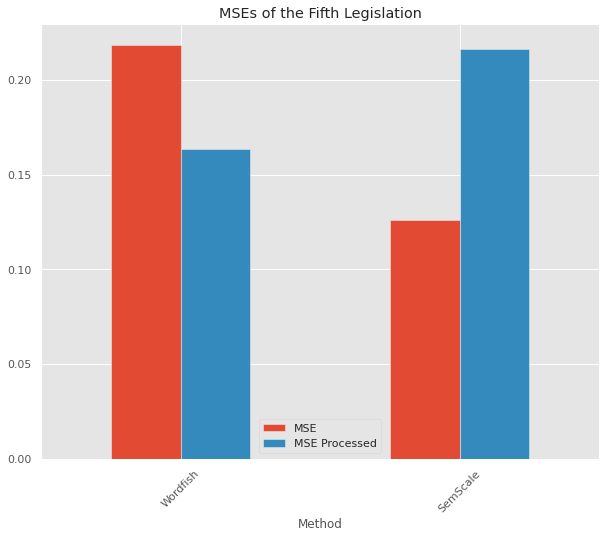

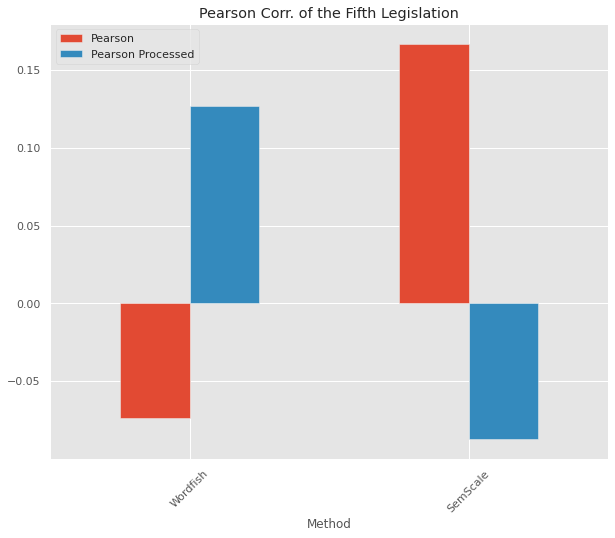

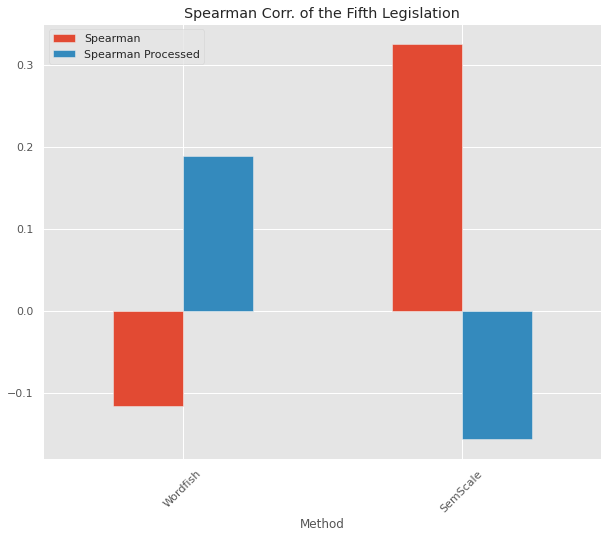

In [33]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')
ax1 = metrics_fifth_df[["MSE", "MSE Processed"]].plot.bar(title="MSEs of the Fifth Legislation", rot=45)
ax2 = metrics_fifth_df[["Pearson", "Pearson Processed"]].plot.bar(title="Pearson Corr. of the Fifth Legislation", rot=45)
ax3 = metrics_fifth_df[["Spearman", "Spearman Processed"]].plot.bar(title="Spearman Corr. of the Fifth Legislation", rot=45)

fig_dir = "figs/Paper Replication/"
ax1.get_figure().savefig(fig_dir + "5th Legislation MSE" + ".pdf")
ax1.get_figure().savefig(fig_dir + "5th Legislation MSE" + ".svg")

ax2.get_figure().savefig(fig_dir + "5th Legislation Pearson"  + ".pdf")
ax2.get_figure().savefig(fig_dir + "5th Legislation Pearson"  + ".svg")

ax3.get_figure().savefig(fig_dir + "5th Legislation Spearman"  + ".pdf")
ax3.get_figure().savefig(fig_dir + "5th Legislation Spearman"  + ".svg")

plt.show()

We now plot the **MSEs, Pearson Correlations and Spearman Correlations** of the **6th legislation**:

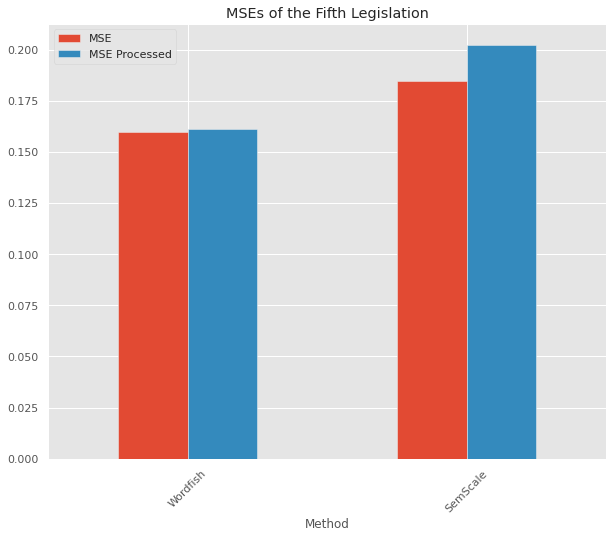

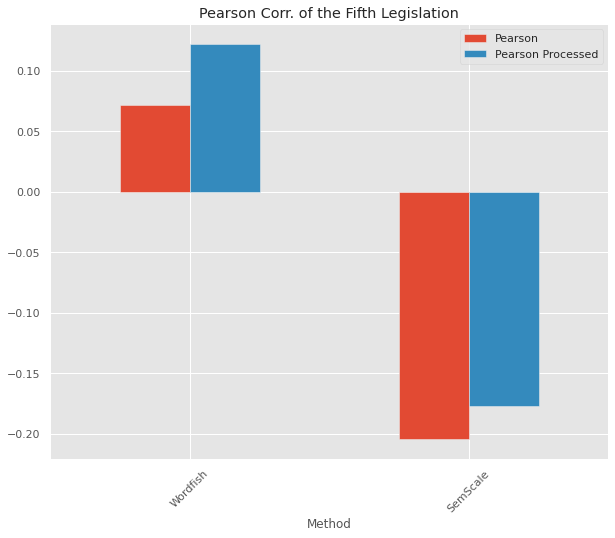

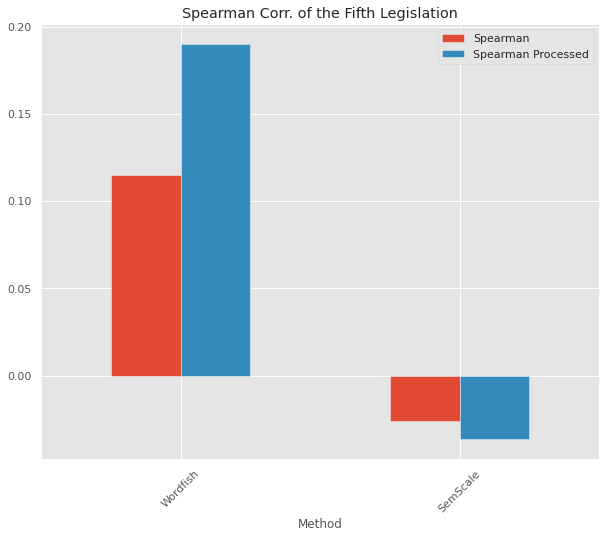

In [34]:
ax4 = metrics_sixth_df[["MSE", "MSE Processed"]].plot.bar(title="MSEs of the Fifth Legislation",rot=45)
ax5 = metrics_sixth_df[["Pearson", "Pearson Processed"]].plot.bar(title="Pearson Corr. of the Fifth Legislation",rot=45)
ax6 = metrics_sixth_df[["Spearman", "Spearman Processed"]].plot.bar(title="Spearman Corr. of the Fifth Legislation",rot=45)

fig_dir = "figs/Paper Replication/"
ax1.get_figure().savefig(fig_dir + "6th Legislation MSE" + ".pdf")
ax1.get_figure().savefig(fig_dir + "6th Legislation MSE" + ".svg")

ax2.get_figure().savefig(fig_dir + "6th Legislation Pearson"  + ".pdf")
ax2.get_figure().savefig(fig_dir + "6th Legislation Pearson"  + ".svg")

ax3.get_figure().savefig(fig_dir + "6th Legislation Spearman"  + ".pdf")
ax3.get_figure().savefig(fig_dir + "6th Legislation Spearman"  + ".svg")

plt.show()

**Results for the 5th legislation:**

In [35]:
metrics_fifth_df.to_csv("results/paper_replication_fifth_leg_results.csv")
metrics_fifth_df

,MSE,MSE Processed,Pearson,Pearson Processed,Spearman,Spearman Processed
Method,,,,,,
Wordfish,0.218614,0.163298,-0.073632,0.126860,-0.116600,0.188919
SemScale,0.126091,0.216385,0.167037,-0.087255,0.326218,-0.156541


**Results for the 6th legislation:**

In [36]:
metrics_fifth_df.to_csv("results/paper_replication_sixth_leg_results.csv")
metrics_sixth_df

,MSE,MSE Processed,Pearson,Pearson Processed,Spearman,Spearman Processed
Method,,,,,,
Wordfish,0.159763,0.161225,0.071620,0.122643,0.114681,0.190311
SemScale,0.184793,0.202531,-0.204416,-0.176908,-0.025974,-0.036364
